# Mobile Robotics Project 
## Groupe 47

| Name      | ID      |
|-----------|---------|
| Martin    | 340936  |
| Laetitia  | XXXXXX  |
| Arthur    | 300443  |
| Amandine  | 344736  |

A **Jupyter notebook** which serves as a report. This must contain the information regarding :
- The **members of the group**, it’s helpful to know who you are when we go over the report.
- An **introduction to your environment** and to the **choices you made**.
- Sections that go into a bit **more detail regarding the implementation** and are accompanied by the code required to **execute the different modules independently**. What is important is not to simply describe the code, which should be readable, but describe what is not in the code: the theory behind, the choices made, the measurements, the choice of parameters etc. Do not forget to **cite your sources** ! You can of course show how certain modules work in **simulation here, or with pre-recorded data**.
- A section which is used to **run the overall project** and where we can see the path chosen, where the system believes the robot is along the path before and after filtering etc… This can also be done **in a .py file** if you prefer. Just make sure to reference it in the report so we can easily have a look at it.
- Conclusion: The code used to execute the overall project. Do not hesitate to **make use of .py files** that you import in the notebook. The whole body of code does not have to be in the Jupyter notebook, on the contrary! Make sure the **code clean and well documented**. Somebody who starts to browse through it should easily understand what you are doing.

# Initialization

Using a camera, we detect the scene and do path planning using $A*$

1. From camera, capture images at rate $1/f$
2. Find edges
3. Find corners of edges
4. Correct distortion (realign)
5. Threshold colors and components size
6. Discretize to get the grid
7. Compute centroids and enlarged objects

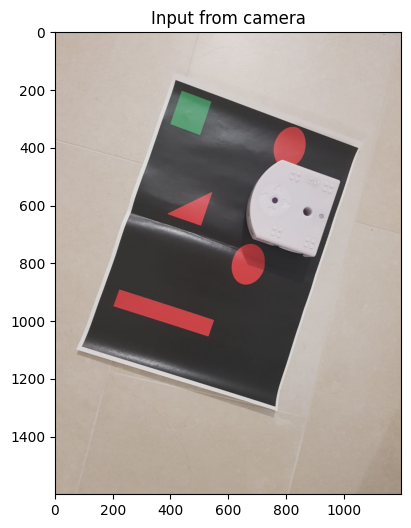

Image shape: (1600, 1200, 3), pixels: 1920000


In [1]:
from libs.vision import get_image_from_file, correct_distortion, threshold_image, get_grid
from libs.vision import get_centroids, get_nose, get_orientation, grid_to_image, image_to_grid
from libs.plot import show_cv2_image, show_distortion, show_thresholds, show_grid, show_nose
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

image = get_image_from_file(os.path.join("robot-env", "r2.jpg"))
show_cv2_image(image, fig_size=(6,6), color="BGR", _title="Input from camera")
print(f"Image shape: {image.shape}, pixels: {image.shape[0]*image.shape[1]}")

In [2]:
show_distortion(image)

interactive(children=(FloatSlider(value=5.0, description='Sigma', max=10.0, min=1.0), FloatSlider(value=0.0025…

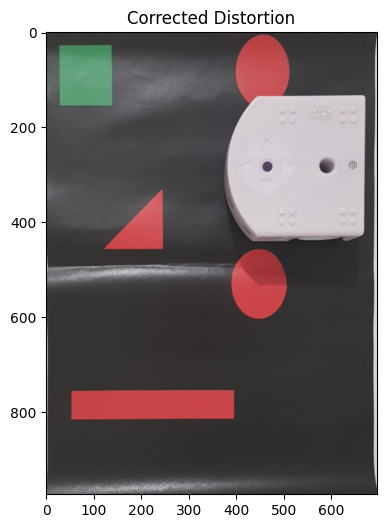

In [3]:
image = correct_distortion(image, sigma=5, epsilon=0.01) # espilon can be large for security
show_cv2_image(image, fig_size=(6,6), color="BGR", _title="Corrected Distortion")

In [4]:
show_thresholds(image)

interactive(children=(IntSlider(value=190, description='T_WL', max=255), IntSlider(value=140, description='T_R…

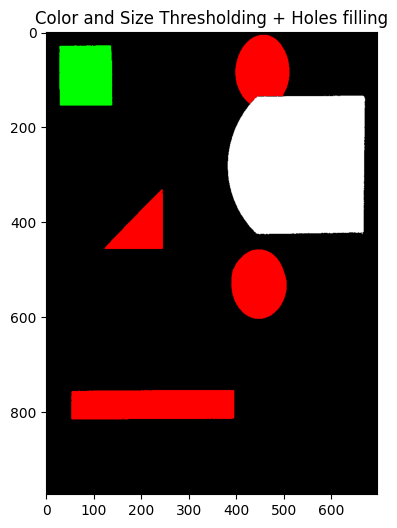

In [5]:
# white lower bound (190,190,190) < (b,g,r) < (255,255,255)
T_WL=190

# (0,0,T_RL) < (b,g,r) < (T_RH,T_RH,255)
T_RH=170 # blue green upper bound for red
T_RL=120 # red lower bound for red

# (0,T_GL,0) < (b,g,r) < (T_GH,255,T_GH)
T_GH=140 # blue red upper bound for green
T_GL=120 # green lower bound for green

min_size=5000

image = threshold_image(image, T_WL, T_RH, T_RL, T_GH, T_GL, min_size)
show_cv2_image(image, fig_size=(6,6), color="BGR", _title="Color and Size Thresholding + Holes filling")

Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle
Collision start with obstacle


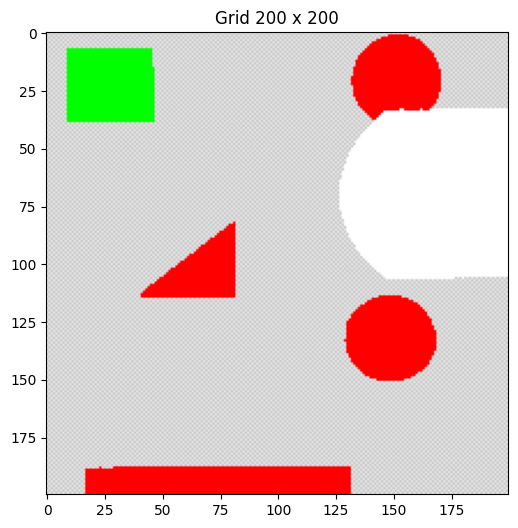

In [6]:
grid = get_grid(image, grid_size=200, verbose=True, full_output=False)
show_grid(grid)

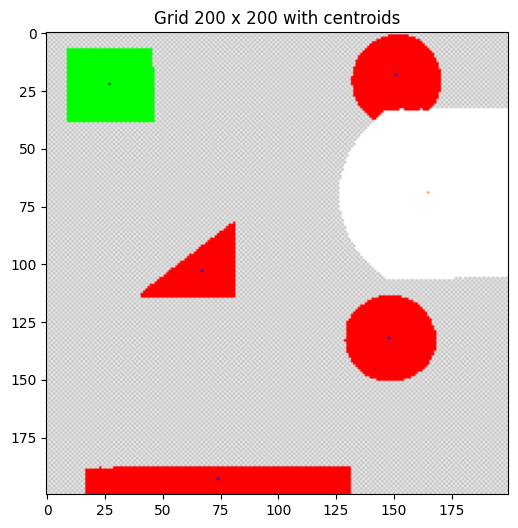

In [7]:
c_obstacles = get_centroids(grid, "obstacle")
c_robot = get_centroids(grid, "start")
c_goal = get_centroids(grid, "goal")
show_grid(grid, (6,6), c_obstacles, c_robot, c_goal)

In [8]:
show_nose(image)

interactive(children=(FloatSlider(value=5.0, description='Sigma', max=10.0, min=1.0), IntSlider(value=50, desc…

In [9]:
nose = get_nose(image)
centroid = get_centroids(image, [255,255,255]).flatten()
_, angle_deg = get_orientation(nose, centroid)
print(nose, centroid, angle_deg) # in image coords, not grid

[382 283] [533 279] 178.48258587498788


In [10]:
from libs.vision import grid_to_image
grid_image = grid_to_image(grid)
show_nose(grid_image)

interactive(children=(FloatSlider(value=5.0, description='Sigma', max=10.0, min=1.0), IntSlider(value=50, desc…

# Localization Updates

We are only interested in the robot

Camera helps localization + kalman filter